# Object Tracking using SIFT

Now that I understand SIFT to an extent, I want to use it to track something. I saw a set of coasters on the table that my parents bought, so I recorded myself on my crappy mac webcam moving this thing around. I'm going to try and track it, and then do something with it to demonstrate what I can use this for. 

I'm going to try and apply a blur on it. This might be useful if, for example, I'm recording a video to post online and this object I was "showcasing" contains a barcode or a label on an Amazon package that had my name and address on it. I'd want to blur that out and have the blur follow the label in the frame automatically so I don't get doxxed. Again, a lot of editing software can do this. I wanted to learn how it works. What better way to do that than trying to code an object tracker yourself

In [33]:
from IPython.display import Video
from pathlib import Path
from anutils import data_path
import matplotlib
matplotlib.rcParams['figure.figsize'] = [f*2.5 for f in [3, 2]]
from matplotlib import pyplot as plt
from contextlib import contextmanager
import numpy as np
import cv2

video_file = data_path / 'object-tracking-video.mp4'

@contextmanager
def load_video(path):
    """
    Safely open and manage video file
    """
    if isinstance(path, Path):
        path = str(path)
    cap = cv2.VideoCapture(path)
    yield cap
    cap.release()


def display_image(image):
    """
    Cleanly display image using matplotlib
    """
    plt.imshow(image[:,:,[2,1,0]]) # Have to reverse blue and red
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Here's my dumb video lmao
Video(str(video_file), embed=True, width=600, height=400)

## Define Object

I'll take the first frame of the video and draw a box around the object I want to track. We will need to split the "space" into what is and is not the object

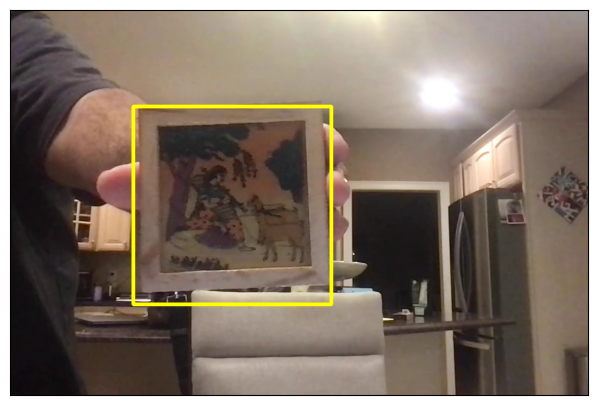

In [34]:
initial_object_rect = (230, 180, 370, 370)

# Load frame
with load_video(video_file) as cap:
    ret, frame = cap.read()

# Draw bounding rectangle on image
x, y, w, h = initial_object_rect
tl = (x, y)
br = (x+w, y+h)
dframe = cv2.rectangle(frame.copy(), tl, br, (0, 255, 255), 5)

# Display image with object highlighted
display_image(dframe)

Now we'll run the frame through the SIFT detector. I'll color the object and background features separately

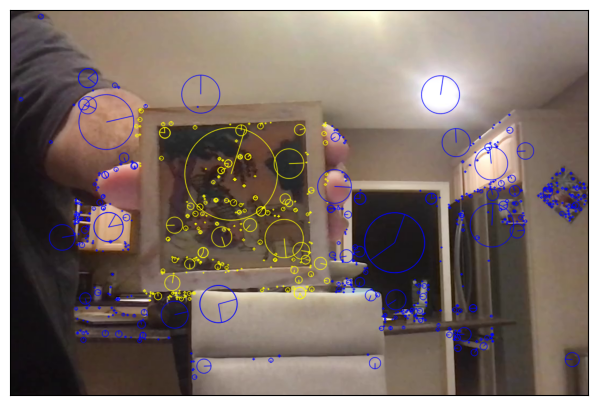

In [38]:
sft = cv2.SIFT.create()
keypoints, descriptors = sft.detectAndCompute(frame, None)

def in_object_test(kp):
    x0, y0, w, h = initial_object_rect
    x1, y1 = x0 + w, y0 + h
    x, y = kp.pt
    r = kp.size/2
    return all([
        x - r > x0,
        x + r < x1,
        y - r > y0,
        y + r < y1
    ])

object_idx = np.array([i for i,k in enumerate(keypoints) if in_object_test(k)])
background_idx = np.array([i for i,k in enumerate(keypoints) if not in_object_test(k)])

object_kp = [keypoints[i] for i in object_idx]
object_dsc = descriptors[object_idx,:]
background_kp = [keypoints[i] for i in background_idx]
background_dsc = descriptors[background_idx,:]

kp_draw_flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
kframe = frame.copy()
cv2.drawKeypoints(kframe, object_kp, kframe, color=(0, 255, 255), flags=kp_draw_flags)
cv2.drawKeypoints(kframe, background_kp, kframe, color=(255, 0, 0), flags=kp_draw_flags)

display_image(kframe)